In [1]:
import os
import numpy as np
import pandas as pd
import json
import gensim
import re
import pandas as pd
import gc
import networkx as nx
from scipy.sparse import lil_matrix
from scipy.io import mmwrite, mmread
from collections import defaultdict

aminer_dir = '../data/original'
outputDir = '../data/graph'
word2vec = gensim.models.KeyedVectors.load_word2vec_format('../data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

/Users/shohei/.pyenv/versions/anaconda3-5.3.0/envs/tensorenv/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [2]:
import datetime
date2 = datetime.datetime.now()
print(date2)

2021-01-12 09:21:25.349017


In [3]:
#attribute_set = {'title', 'authors', 'venue', 'year', 'n_citation', 'references', 'abstract'}
attribute_set = {'title', 'venue', 'year', 'references'}

paper = {}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
#for file in ['dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if attribute_set & data.keys() != attribute_set:
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if empty_flag == 0:
                paper[paper_id] = data

len(paper)

2154706

In [4]:
venue_list = list(pd.read_table("venue3.csv")['venue'])
venue_list = venue_list[:-4] # OSは除去
print(len(venue_list))

10


/Users/shohei/.pyenv/versions/anaconda3-5.3.0/envs/tensorenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
paper = {}
attribute_set = {'title', 'venue', 'year', 'references'}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if attribute_set & data.keys() != attribute_set:
                continue
            if data['year'] >= 2014: # 2014以降は使わない
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if empty_flag == 0:
                if data['venue'] in venue_list:
                    #if data['year'] == 2017:
                    #    data['year'] = 2016
                    paper[paper_id] = data

len(paper)

41611

In [6]:
venue_count_dic = {}
for venue in venue_list:
    venue_count_dic[venue] = 0

for paper_id, meta in paper.items():
    venue_count_dic[meta['venue']] += 1

In [7]:
""""
G = nx.Graph()
year = 2018
paper_id_set = set()

for paper_id, meta in paper.items():
    if year < meta['year']:
        continue
    paper_id_set.add(paper_id)
print("node num : ",len(paper_id_set))

for paper_id in paper_id_set:
    G.add_node(paper_id)
    for reference_id in paper[paper_id]['references']:
        if not reference_id in paper_id_set:
            continue
        G.add_edge(paper_id, reference_id)
print("edge num : ",len(G.edges))
"""

'"\nG = nx.Graph()\nyear = 2018\npaper_id_set = set()\n\nfor paper_id, meta in paper.items():\n    if year < meta[\'year\']:\n        continue\n    paper_id_set.add(paper_id)\nprint("node num : ",len(paper_id_set))\n\nfor paper_id in paper_id_set:\n    G.add_node(paper_id)\n    for reference_id in paper[paper_id][\'references\']:\n        if not reference_id in paper_id_set:\n            continue\n        G.add_edge(paper_id, reference_id)\nprint("edge num : ",len(G.edges))\n'

In [8]:
"""
connected_component = {}
max_scale = 0
for c in nx.connected_components(G):
    sg = G.subgraph(c)
    if max_scale < len(sg.nodes):
        max_scale = len(sg.nodes)
        max_sg = G.subgraph(c)
    if not len(sg.nodes) in connected_component.keys():
        connected_component[len(sg.nodes)] = 1
    else:
        connected_component[len(sg.nodes)] += 1
connected_component
"""

'\nconnected_component = {}\nmax_scale = 0\nfor c in nx.connected_components(G):\n    sg = G.subgraph(c)\n    if max_scale < len(sg.nodes):\n        max_scale = len(sg.nodes)\n        max_sg = G.subgraph(c)\n    if not len(sg.nodes) in connected_component.keys():\n        connected_component[len(sg.nodes)] = 1\n    else:\n        connected_component[len(sg.nodes)] += 1\nconnected_component\n'

In [9]:
"""
node_idx_table = {}
for idx, node in enumerate(max_sg.nodes):
    node_idx_table[node] = idx
"""

'\nnode_idx_table = {}\nfor idx, node in enumerate(max_sg.nodes):\n    node_idx_table[node] = idx\n'

In [10]:
node_idx_table = {}
for idx, node in enumerate(paper.keys()):
    node_idx_table[node] = idx

In [11]:
rows = []
for node, idx in node_idx_table.items():
    rows.append([node, idx])
df = pd.DataFrame(rows, columns=['node', 'ID'])
df.to_csv(outputDir + '/node_idx.csv', index=False, encoding='utf_8_sig')

In [12]:
"""
paper = {}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
#for file in ['dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if not paper_id in node_idx_table:
                continue
            if attribute_set & data.keys() != attribute_set:
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if empty_flag == 0:
                paper[paper_id] = data

len(paper)
"""

"\npaper = {}\nfor file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:\n#for file in ['dblp-ref-3.json']:\n    with open(os.path.join(aminer_dir, file)) as f:\n        for line in f:\n            empty_flag = 0\n            data = json.loads(line)\n            paper_id = data.pop('id')\n            if not paper_id in node_idx_table:\n                continue\n            if attribute_set & data.keys() != attribute_set:\n                continue\n            for attribute in attribute_set:\n                if attribute == 'year' or attribute == 'n_citation':\n                    continue\n                if len(data[attribute]) == 0:\n                    empty_flag = 1\n            if empty_flag == 0:\n                paper[paper_id] = data\n\nlen(paper)\n"

In [13]:
#venue_set = set()
#for paper_id, meta in paper.items():
#    venue_set.add(meta['venue'])

In [14]:
#df = pd.DataFrame({'venue': list(venue_set)})
#df.to_csv("venue.csv")

In [15]:
years = set()
for paper_id, meta in paper.items():
    years.add(paper[paper_id]['year'])
years = list(years)
years.sort()
years

[1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013]

In [16]:
venue_list

['international world wide web conferences',
 'Artificial Intelligence',
 'international conference on neural information processing',
 'knowledge discovery and data mining',
 'international acm sigir conference on research and development in information retrieval',
 'international conference on management of data',
 'human factors in computing systems',
 'meeting of the association for computational linguistics',
 'computer vision and pattern recognition',
 'international conference on computer communications']

In [17]:
#field_list = ["WEB", "ML", "DM", "IR", "DB", "HI", "NLP", "CV", "COM", "OS"]
field_list = ["WEB", "ML", "DM", "IR", "DB", "HI", "NLP", "CV", "COM"]
field_venue_dic = defaultdict(list)

for idx, venue in enumerate(venue_list):
    if idx < 1:
        field_venue_dic["WEB"].append(venue)
    elif idx < 3:
        field_venue_dic["ML"].append(venue)
    elif idx < 4:
        field_venue_dic["DM"].append(venue)
    elif idx < 5:
        field_venue_dic["IR"].append(venue)
    elif idx < 6:
        field_venue_dic["DB"].append(venue)
    elif idx < 7:
        field_venue_dic["HI"].append(venue)
    elif idx < 8:
        field_venue_dic["NLP"].append(venue)
    elif idx < 9:
        field_venue_dic["CV"].append(venue)
    elif idx < 10:
        field_venue_dic["COM"].append(venue)
    #else:
    #    field_venue_dic["OS"].append(venue)

field_venue_dic

defaultdict(list,
            {'WEB': ['international world wide web conferences'],
             'ML': ['Artificial Intelligence',
              'international conference on neural information processing'],
             'DM': ['knowledge discovery and data mining'],
             'IR': ['international acm sigir conference on research and development in information retrieval'],
             'DB': ['international conference on management of data'],
             'HI': ['human factors in computing systems'],
             'NLP': ['meeting of the association for computational linguistics'],
             'CV': ['computer vision and pattern recognition'],
             'COM': ['international conference on computer communications']})

In [18]:
field_count_dic = {}
for field in field_list:
    field_count_dic[field] = 0

for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    field_count_dic[field] += 1

field_count_dic

{'WEB': 3311,
 'ML': 3941,
 'DM': 3685,
 'IR': 2929,
 'DB': 3192,
 'HI': 8062,
 'NLP': 3531,
 'CV': 7481,
 'COM': 5479}

In [19]:
year_field_count = np.zeros((len(years), len(field_list)))
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    year_field_count[years.index(meta['year'])][field_list.index(field)] +=1

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

for f_idx in range(len(field_list)):
    plt.plot(years, year_field_count[:, f_idx], label=field_list[f_idx])
plt.xlabel("year")
plt.ylabel("the # of papers")
plt.legend()
plt.savefig("num_of_paper_field.pdf")

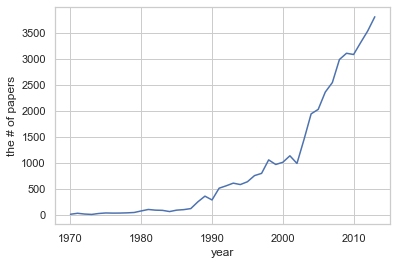

In [21]:
plt.figure()
plt.plot(years, year_field_count.sum(axis=1))
plt.xlabel("year")
plt.ylabel("the # of papers")
plt.savefig("num_of_paper.pdf")

In [22]:
node_attribute = np.zeros((len(node_idx_table), 300))
for paper_id, meta in paper.items():
    vector = np.zeros((300))
    #print(meta['title'])
    n_word = 0
    for word in meta['title'].split(' '):
        try:
            vector = vector + word2vec[word]
            n_word += 1
            #print(word)
        except KeyError as error:
            pass
            #print(error)
    if n_word == 0:
        node_attribute[node_idx_table[paper_id]] = vector
    else:
        node_attribute[node_idx_table[paper_id]] = vector / n_word
    #print(node_attribute[node_idx_table[paper_id]])
    #print(" ")

In [23]:
# 低次元に写像しクラスタを可視化
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
node_attribute_pca = pca.fit_transform(node_attribute)
print(node_attribute_pca.shape)

(41611, 2)


In [24]:
n_clusters = len(field_list)
x_field = [[] for _ in range(n_clusters)]
y_field = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    i = field_list.index(field)
    x_field[i].append(node_attribute_pca[node_idx_table[paper_id]][0])
    y_field[i].append(node_attribute_pca[node_idx_table[paper_id]][1])

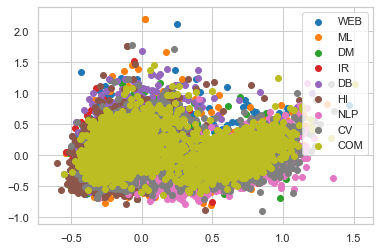

In [25]:
import matplotlib.colors as mcolors
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = [val for key, val in mcolors.TABLEAU_COLORS.items()]

for i in range(n_clusters):
    ax.scatter(x_field[i], y_field[i], c=colors[i], label=field_list[i])

ax.legend()
fig.savefig('scatter_word2vec.pdf')

In [26]:
# 分野ごとの論文を抽出して連結し文書化する。

def Isalnum(s):
    alnumReg = re.compile(r'^[a-zA-Z0-9]+$')
    return alnumReg.match(s) is not None

n_clusters = len(field_list)

cluster_title_list = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    cluster_title_list[field_list.index(field)].append(meta['title'])

documents = []
for title_list in cluster_title_list:
    title_list = ' '.join(title_list)
    title_list = str.lower(title_list)
    notalnum = set()
    for s in set(title_list):
        if s != ' ' and not Isalnum(s):
            notalnum.add(s)
            #print(s) # 記号（文字や数値でないもの）
    for s in notalnum:
        title_list = title_list.replace(s, ' ')
    documents.append(title_list)

In [27]:
# TF-IDFを計算し、各クラスタごとの代表的な単語を上位数件表示する。

from gensim import corpora
from gensim import models

# gensim用に整形
texts = list(map(lambda x:x.split(),documents))

# 単語->id変換の辞書作成
dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

# textsをcorpus化
corpus = list(map(dictionary.doc2bow,texts))
#print(corpus)

# tfidf modelの生成
test_model = models.TfidfModel(corpus)

# corpusへのモデル適用
corpus_tfidf = test_model[corpus]

texts_tfidf = []
for doc in corpus_tfidf:
    text_tfidf = []
    for word in doc:
        text_tfidf.append((dictionary[word[0]],word[1]))
    texts_tfidf.append(text_tfidf)

keyword_tfidf_cluster_list = []
for idx, text in enumerate(texts_tfidf):
    print(field_list[idx])
    keyword_tfidf_cluster_list.append({})
    for keyword in sorted(text, key=lambda x:(x[1]), reverse=True)[:150]:
        print('   %.3f %s' %(keyword[1], keyword[0]))
        keyword_tfidf_cluster_list[idx][keyword[0]] = keyword[1]

WEB
   0.401 xml
   0.301 rdf
   0.160 crawling
   0.158 hypermedia
   0.141 semantic
   0.140 sparql
   0.123 http
   0.115 owl
   0.102 xslt
   0.092 caching
   0.092 www
   0.090 ws
   0.088 crawler
   0.086 browser
   0.082 service
   0.080 servers
   0.075 pagerank
   0.070 peer
   0.067 twitter
   0.064 restful
   0.064 smil
   0.063 server
   0.061 website
   0.061 javascript
   0.061 rss
   0.058 mashup
   0.058 urls
   0.057 proxy
   0.056 click
   0.055 publishing
   0.053 browsers
   0.053 compositions
   0.053 earthquake
   0.053 matchmaking
   0.052 media
   0.052 spam
   0.051 communities
   0.051 folksonomies
   0.051 middleware
   0.051 observatory
   0.051 oxpath
   0.051 webml
   0.047 advertising
   0.047 wikipedia
   0.045 delivery
   0.045 lifecycle
   0.045 mashups
   0.045 xquery
   0.044 advertiser
   0.044 blogging
   0.044 bpel
   0.044 pdas
   0.043 articles
   0.043 authoring
   0.043 html
   0.043 url
   0.041 sponsored
   0.040 p2p
   0.040 site
   0.038 p

In [28]:
#for paper_id, meta in paper.items():
#    if 'sigir' in str.lower(meta['title']):
#        print(meta['title'])

In [29]:
#key_ = ["WWW_keyword", "WWW_score", "ML_keyword", "ML_score", "DM_keyword", "DM_score", "IR_keyword", "IR_score", "DB_keyword", "DB_score", "HI_keyword", "HI_score", "NLP_keyword", "NLP_score", "CV_keyword", "CV_score", "COM_keyword", "COM_score", "OS_keyword", "OS_score"]
key_ = ["WWW_keyword", "WWW_score", "ML_keyword", "ML_score", "DM_keyword", "DM_score", "IR_keyword", "IR_score", "DB_keyword", "DB_score", "HI_keyword", "HI_score", "NLP_keyword", "NLP_score", "CV_keyword", "CV_score", "COM_keyword", "COM_score"]
val_ = []
for idx in range(n_clusters):
    val_.append([keyword for keyword, score in keyword_tfidf_cluster_list[idx].items()])
    val_.append([score for keyword, score in keyword_tfidf_cluster_list[idx].items()])
dic = {key_[i] : val_[i] for i in range(len(key_))}
df = pd.DataFrame(dic)
df.to_csv("field_tfidf.csv")
df.head()

,WWW_keyword,WWW_score,ML_keyword,ML_score,DM_keyword,DM_score,IR_keyword,IR_score,DB_keyword,DB_score,HI_keyword,HI_score,NLP_keyword,NLP_score,CV_keyword,CV_score,COM_keyword,COM_score
0,xml,0.400929,spiking,0.324246,kdd,0.585068,sigir,0.303038,dbms,0.406384,hci,0.321239,parsing,0.220020,stereo,0.462235,atm,0.346221
1,rdf,0.301026,logics,0.249420,cup,0.386563,workshop,0.205044,sql,0.380985,tangible,0.270476,adjoining,0.182854,pose,0.237404,packet,0.324833
2,crawling,0.160120,neuro,0.199536,frequent,0.212075,passage,0.184391,xml,0.315268,pointing,0.173720,dialogue,0.180010,registration,0.223036,multicast,0.296761
3,hypermedia,0.157836,nonmonotonic,0.165045,itemsets,0.167162,xml,0.171141,olap,0.180820,tabletop,0.160619,parser,0.175539,photometric,0.184247,802,0.256658
4,semantic,0.141453,neural,0.163563,discovered,0.092973,trec,0.168354,warehousing,0.152394,de,0.157092,pos,0.168225,illumination,0.177016,wdm,0.248637


In [30]:
#用いるキーワード数
n_used_keyword = 50
field_used_keyword = {}

field_attribute = np.zeros((len(field_list), 300))
for field in range(n_clusters):
    vector = np.zeros((300))
    n_word = 0
    #weight = n_used_keyword
    weight = 0
    used_keyword = []
    for word in val_[field * 2]:
        try:
            #vector = vector + weight * word2vec[word]
            w = keyword_tfidf_cluster_list[field][word]
            vector = vector + w * word2vec[word]
            n_word += 1
            #weight -= 1
            weight += w
            used_keyword.append(word)
            #print(word)
        except KeyError as error:
            pass
            #print(word)
        if n_word == n_used_keyword:
            break
    if n_word == 0 or n_word < n_used_keyword:
        print("あり得ない")
        field_attribute[field] = vector
    else:
        #field_attribute[field] = vector / sum(i for i in range(1, n_used_keyword+1))
        field_attribute[field] = vector / weight
    field_used_keyword[field_list[field]] = used_keyword

In [31]:
df = pd.DataFrame(field_used_keyword)
df.to_csv("used_word.csv")

In [32]:
print(field_attribute.shape)
print(node_attribute.shape)

(9, 300)
(41611, 300)


In [33]:
import sklearn
node_attribute_similar2field = sklearn.metrics.pairwise.cosine_similarity(node_attribute, field_attribute)
node_attribute_similar2field.shape

(41611, 9)

In [34]:
# 低次元に写像しクラスタを可視化
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
node_attribute_pca = pca.fit_transform(node_attribute_similar2field)
print(node_attribute_pca.shape)

(41611, 2)


In [35]:
x_field = [[] for _ in range(n_clusters)]
y_field = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    i = field_list.index(field)
    x_field[i].append(node_attribute_pca[node_idx_table[paper_id]][0])
    y_field[i].append(node_attribute_pca[node_idx_table[paper_id]][1])

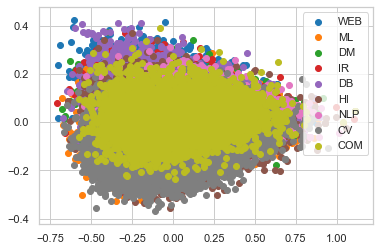

In [36]:
import matplotlib.colors as mcolors
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = [val for key, val in mcolors.TABLEAU_COLORS.items()]

for i in range(n_clusters):
    ax.scatter(x_field[i], y_field[i], c=colors[i], label=field_list[i])

ax.legend()
fig.savefig('scatter_sim2refvec.pdf')

In [37]:
# 低次元に写像しクラスタを可視化
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
field_attribute_pca = pca.fit_transform(field_attribute)
print(field_attribute_pca.shape)

(9, 2)


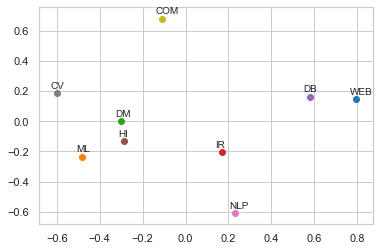

In [38]:
import matplotlib.colors as mcolors
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = [val for key, val in mcolors.TABLEAU_COLORS.items()]

for i in range(n_clusters):
    ax.scatter(field_attribute_pca[i][0], field_attribute_pca[i][1], c=colors[i], label=field_list[i])
    plt.annotate(field_list[i], xy=(field_attribute_pca[i][0]-0.03, field_attribute_pca[i][1]+0.03))

fig.savefig('scatter_field.pdf')

In [39]:
# ここで実際の分野とタイトルのそれらしさの一致率をチェック
for paper_id, meta in sorted(paper.items())[:10]:
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    print(field, field_list[node_attribute_similar2field[node_idx_table[paper_id]].argmax()])
    print(meta['title'])

HI HI
Designing mobile phone interface with children
NLP IR
A Logic-Based Semantic Approach to Recognizing Textual Entailment
IR IR
Commodity query by snapping
DB CV
The NAOS system
NLP IR
Query-based Sentence Fusion is Better Defined and Leads to More Preferred Results than Generic Sentence Fusion
HI CV
One size does not fit all: applying the transtheoretical model to energy feedback technology design
COM COM
Scalable live video streaming to cooperative clients using time shifting and video patching
CV CV
Automatic Removal of Chromatic Aberration from a Single Image
ML ML
Hierarchical model-based diagnosis based on structural abstraction
DM IR
Joint cluster analysis of attribute and relationship data withouta-priori specification of the number of clusters


In [40]:
node_attribute_similar2field

array([[0.57839472, 0.2528262 , 0.31534073, ..., 0.38728023, 0.2429045 ,
        0.23355384],
       [0.37995417, 0.36904887, 0.44747075, ..., 0.3509914 , 0.34515584,
        0.31273769],
       [0.2636935 , 0.34749593, 0.34320935, ..., 0.30414193, 0.28809012,
        0.22016882],
       ...,
       [0.34500418, 0.32917013, 0.36368884, ..., 0.3254499 , 0.43279538,
        0.42438328],
       [0.46230775, 0.39878121, 0.46407333, ..., 0.4024341 , 0.39209399,
        0.45824267],
       [0.41492766, 0.37711015, 0.4412157 , ..., 0.30357599, 0.34777319,
        0.41238484]])

In [41]:
rows = []
for idx, ts in enumerate(years):
    rows.append([ts, idx])
df = pd.DataFrame(rows, columns=['TS', 'ID'])
df.to_csv(outputDir + '/ts_idx.csv', index=False, encoding='utf_8_sig')

In [42]:
df = pd.read_csv(outputDir + '/ts_idx.csv')
df_TS = df.TS.values
df_ID = df.ID.values
ts_idx_table = {}
for row in range(df.shape[0]):
    ts_idx_table[df_TS[row]] = df_ID[row]

In [43]:
exist_table = np.zeros((len(node_idx_table), len(ts_idx_table)))
for year in years:
    for paper_id, meta in paper.items():
        if year < meta['year']:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 0
        else:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 1

np.save(outputDir + '/exist_table', exist_table)

In [44]:
for year in years:
    node_attribute = np.zeros((len(node_idx_table), len(field_list)))
    index = exist_table[:, ts_idx_table[year]] == 1
    node_attribute[index] = node_attribute_similar2field[index]
    np.save(outputDir + '/node_attribute' + str(ts_idx_table[year]), node_attribute)

In [45]:
for year in years:
    adjacency = lil_matrix((len(node_idx_table), len(node_idx_table)))
    for paper_id, meta in paper.items():
        if year < meta['year']:
            continue
        for reference_id in meta['references']:
            if not reference_id in node_idx_table.keys():
                continue
            adjacency[node_idx_table[paper_id], node_idx_table[reference_id]] = 1
    mmwrite(outputDir + '/adjacency' + str(ts_idx_table[year]), adjacency)

In [131]:
exist_table.shape

(127980, 50)

In [134]:
exist_table[:, -1] == 1

array([ True,  True,  True, ...,  True,  True,  True])

In [136]:
node_attribute_similar2field.shape

(127980, 9)

In [137]:
len(field_list)

9

In [ ]:
# 従来の問題点1 : connected component は1だが、必ずしもnew nodeのreference先が存在するとは限らない
# 従来の問題点2 : 今回はnew node予測のみなので必ずしもexisting node の隣接行列等は必要ない
# 従来の問題点3 : サイズが大きすぎてdeep learningができない
# 従来の問題点4 : 属性のその他が多すぎる問題

# 方針1 : new nodeがreference先を1つ以上持つものをサンプリングする
# 方針2 : original (2118551)のグラフが持つ属性の割合を保持する (e.g. 1990年はdb:0.8, ml:0.2、1990年はdb:0.6, ml:0.4、・・・) ようにnew nodeをサンプリングする
# 方針3 : 方針1と方針2を満たすnew nodeとそのreference先のセットを1サンプルとする

# 方針3で作成されたグラフを時系列に組み合わせて新たな時系列グラフを作り直す。
# ただし、各サンプル（各タイムステップ）のexisting node（reference先のノード）はそのタイミングのみ存在するものとする。
# 次のタイミングでは過去のnew nodeもexisting nodeも消失ノードとする（new node 予測のみなので、消失予測は関係無い）
# new node & existing nodeが新たに出現し、すぐさま消失するイメージ
# new nodeの出現数もoriginalの等縮小倍率とする
#（本当は過去ノードは消失ノード扱いのため存在していないが）グラフとしてはサブサンプルされたnew node & existing nodeの累積個数とする。
# この方法で作成すれば一応、new nodeの数と属性の統計量を保持したままグラフを削れる

# → まずはグラフサイズを削る前に年ごとの属性の割合を明らかにする

In [ ]:
# 年ごとのpaper_id の辞書を作成
year_paper_dic = {}
for year in years:
    year_paper_dic[year] = []
for paper_id, meta in paper.items():
    year_paper_dic[meta['year']].append(paper_id)

# 年ごとのnew nodeの数を表示
for year in years:
    print(year, len(year_paper_dic[year]))

In [ ]:
node_attribute = np.zeros((len(node_idx_table), 300))
for paper_id, meta in paper.items():
    vector = np.zeros((300))
    #print(meta['title'])
    n_word = 0
    for word in meta['title'].split(' '):
        try:
            vector = vector + word2vec[word]
            n_word += 1
            #print(word)
        except KeyError as error:
            pass
            #print(error)
    if n_word == 0:
        node_attribute[node_idx_table[paper_id]] = vector
    else:
        node_attribute[node_idx_table[paper_id]] = vector / n_word
    #print(node_attribute[node_idx_table[paper_id]])
    #print(" ")

In [ ]:
# zero vectorの件数 (タイトル内のどの単語もword2vecのカバー範囲に含まれなかった件数)
sum(np.abs(node_attribute.sum(axis=1)) < 0.0000001)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
n_clusters = 10
kmeans_model = MiniBatchKMeans(n_clusters=n_clusters, batch_size=3000, random_state=42, max_iter=1000000, max_no_improvement=10000)
kmeans_model.fit(node_attribute)

In [ ]:
kmeans_model.labels_

In [ ]:
# 論文のラベルとしてcluster key を追加
for paper_id, meta in paper.items():
    paper[paper_id]["cluster"] = kmeans_model.labels_[node_idx_table[paper_id]]

In [ ]:
# クラスタごとの論文を抽出して連結し文書化する。

def Isalnum(s):
    alnumReg = re.compile(r'^[a-zA-Z0-9]+$')
    return alnumReg.match(s) is not None

cluster_title_list = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    cluster_title_list[meta['cluster']].append(meta['title'])

documents = []
for title_list in cluster_title_list:
    title_list = ' '.join(title_list)
    title_list = str.lower(title_list)
    notalnum = set()
    for s in set(title_list):
        if s != ' ' and not Isalnum(s):
            notalnum.add(s)
            #print(s) # 記号（文字や数値でないもの）
    for s in notalnum:
        title_list = title_list.replace(s, ' ')
    documents.append(title_list)

In [ ]:
# TF-IDFを計算し、各クラスタごとの代表的な単語を上位数件表示する。

from gensim import corpora
from gensim import models

# gensim用に整形
texts = list(map(lambda x:x.split(),documents))

# 単語->id変換の辞書作成
dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

# textsをcorpus化
corpus = list(map(dictionary.doc2bow,texts))
#print(corpus)

# tfidf modelの生成
test_model = models.TfidfModel(corpus)

# corpusへのモデル適用
corpus_tfidf = test_model[corpus]

texts_tfidf = []
for doc in corpus_tfidf:
    text_tfidf = []
    for word in doc:
        text_tfidf.append((dictionary[word[0]],word[1]))
    texts_tfidf.append(text_tfidf)

keyword_tfidf_cluster_list = []
for idx, text in enumerate(texts_tfidf):
    print('cluster:', idx)
    keyword_tfidf_cluster_list.append({})
    for keyword in sorted(text, key=lambda x:(x[1]), reverse=True)[:10]:
        print('   %.3f %s' %(keyword[1], keyword[0]))
        keyword_tfidf_cluster_list[idx][keyword[0]] = keyword[1]

In [ ]:
keyword_tfidf_cluster_list

In [ ]:
!pip install cmake
!pip install MulticoreTSNE

In [ ]:
# 低次元に写像しクラスタを可視化（めちゃくちゃ遅い！！！）
from MulticoreTSNE import MulticoreTSNE as TSNE
import multiprocessing

print(multiprocessing.cpu_count())
t_sne = TSNE(n_jobs=multiprocessing.cpu_count()).fit_transform(node_attribute)
print('t_sne shape:', t_sne.shape)

In [ ]:
aaa

In [ ]:
# 年ごとのクラスタの割合をプロット (Deep MatchMaxが学習できるヒントがあるかもしれない)

In [ ]:
aaa

In [ ]:
# pandas 高速化 https://kunai-lab.hatenablog.jp/entry/2018/04/08/134924
df = pd.read_csv(outputDir + '/node_idx.csv')
df_node = df.node.values
df_ID = df.ID.values
node_idx_table2 = {}
for row in range(df.shape[0]):
    node_idx_table2[df_node[row]] = df_ID[row]
assert node_idx_table2 == node_idx_table, "いってこいになってない"

del df, df_node, df_ID, node_idx_table2, connected_component, sg, max_sg, paper_id_set, G, paper
gc.collect()

In [ ]:
paper = {}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
#for file in ['dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if not paper_id in node_idx_table:
                continue
            if attribute_set & data.keys() != attribute_set:
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if empty_flag == 0:
                paper[paper_id] = data

len(paper)

In [ ]:
dict_id2title = {}
for paper_id in paper.keys():
    dict_id2title[paper_id] = paper[paper_id]['title']
len(dict_id2title)

In [ ]:
venue_dict = {}
for paper_id, meta in paper.items():
    if meta['venue'] in venue_dict.keys():
        venue_dict[meta['venue']] = venue_dict[meta['venue']] + 1
    else:
        venue_dict[meta['venue']] = 1

venue_list = []
for name, count in sorted(venue_dict.items(), key=lambda x: -x[1]):
    venue_list.append(name)

In [ ]:

def GetListIndex(l, x, default=-1):
    if x in l:
        return l.index(x)
    else:
        return default

def Isalnum(s):
    alnumReg = re.compile(r'^[a-zA-Z0-9]+$')
    return alnumReg.match(s) is not None

venue_list = venue_list[:100]
title_groupby_venue_defaultdict = defaultdict(list)
for paper_id, meta in paper.items():
    if GetListIndex(venue_list, meta['venue']) != -1:
        title_groupby_venue_defaultdict[meta['venue']].append(meta['title'])

document_groupby_venue_dict = {}
for venue in venue_list:
    title_list = title_groupby_venue_defaultdict[venue]
    title_list = ' '.join(title_list)
    title_list = str.lower(title_list)
    notalnum = []
    for s in title_list:
        if s != ' ' and not Isalnum(s):
            notalnum.append(s)
            #print(s) # 記号（文字や数値でないもの）
    for s in notalnum:
        title_list = title_list.replace(s, ' ')
    document_groupby_venue_dict[venue] = title_list

In [ ]:
rows = []
row = ['field', 0, 0, 100, 'VECTOR', True, False, False]
row.extend(sorted(venue_list))
row.extend(['other'])
rows.append(row)
columns = ['name', 'ID', 'range0', 'range1', 'type', 'primary', 'avg', 'cov']
classes = ['class' + str(i) for i in range(len(venue_list) + 1)]
columns.extend(classes)
df = pd.DataFrame(rows, columns=columns)
df.to_csv(outputDir + '/attribute_idx.csv', index=False, encoding='utf_8_sig')

In [ ]:
from gensim import corpora
from gensim import models

documents = []
for venue in venue_list:
    documents.append(document_groupby_venue_dict[venue])
    
# gensim用に整形
texts = list(map(lambda x:x.split(),documents))

# 単語->id変換の辞書作成
dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

# textsをcorpus化
corpus = list(map(dictionary.doc2bow,texts))
#print(corpus)

# tfidf modelの生成
test_model = models.TfidfModel(corpus)

# corpusへのモデル適用
corpus_tfidf = test_model[corpus]

texts_tfidf = []
for doc in corpus_tfidf:
    text_tfidf = []
    for word in doc:
        text_tfidf.append((dictionary[word[0]],word[1]))
    texts_tfidf.append(text_tfidf)

keyword_tfidf_venue_dict = {}
for idx, text in enumerate(texts_tfidf):
    print(venue_list[idx])
    keyword_tfidf_venue_dict[venue_list[idx]] = {}
    for keyword in sorted(text, key=lambda x:(x[1]), reverse=True)[:10]:
        print('   %.3f %s' %(keyword[1], keyword[0]))
        keyword_tfidf_venue_dict[venue_list[idx]][keyword[0]] = keyword[1]

In [ ]:
title_venue_score = {}
for paper_id, meta in paper.items():
    title_venue_score[meta['title']] = {}
    word_list = meta['title'].split(' ')
    for venue, tfidf in keyword_tfidf_venue_dict.items():
        title_venue_score[meta['title']][venue] = 0
        for keyword, score in tfidf.items():
            for word in word_list:
                if keyword == str.lower(word):
                    title_venue_score[meta['title']][venue] = title_venue_score[meta['title']][venue] + score

In [ ]:
title_venue_dict = {}
number = 0
for title, venue_score_dict in title_venue_score.items():
    number += 1
    if number < 100:
        print(title)
    for venue, score in sorted(venue_score_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
        if number < 100:
            print('   %.3f %s' %(score, venue))
    #venue, score = sorted(venue_score_dict.items(), key=lambda x: x[1], reverse=True)[0]
    #if score == 0:
    #    title_venue_dict[title] = 'other'
    #    continue
    #title_venue_dict[title] = venue

In [ ]:
title_venue_dict = {}
for title, venue_score_dict in title_venue_score.items():
    #title_venue_dict[title] = [0 for _ in range(len(venue_list))]
    title_venue_dict[title] = {}
    for venue, score in venue_score_dict.items():
        #title_venue_dict[title][GetListIndex(venue_list, venue)] = score
        title_venue_dict[title][venue] = score
    #score_sum = sum(title_venue_dict[title])
    score_sum = sum([score for venue, score in title_venue_dict[title].items()])
    if score_sum == 0:
        continue
    #for idx, score in enumerate(title_venue_dict[title]):
    #    title_venue_dict[title][idx] = score / score_sum
    for venue, score in title_venue_dict[title].items():
        title_venue_dict[title][venue] = score / score_sum

for title, score_list in title_venue_dict.items():
    if title == 'Evolutionary Chaos Controller Synthesis for Stabilizing Chaotic Hénon Maps.':
        print(title)
        for venue, score in score_list.items():
            print(venue, score)

In [ ]:
years = set()
for paper_id, meta in paper.items():
    years.add(paper[paper_id]['year'])
years = list(years)
years.sort()
years

In [ ]:
rows = []
for idx, year in enumerate(years):
    rows.append([year, idx])
df = pd.DataFrame(rows, columns=['TS', 'ID'])
df.to_csv(outputDir + '/ts_idx.csv', index=False, encoding='utf_8_sig')

In [ ]:
# pandas 高速化 https://kunai-lab.hatenablog.jp/entry/2018/04/08/134924
df = pd.read_csv(outputDir + '/ts_idx.csv')
df_TS = df.TS.values
df_ID = df.ID.values
ts_idx_table = {}
for row in range(df.shape[0]):
    ts_idx_table[df_TS[row]] = df_ID[row]
ts_idx_table

In [ ]:
exist_table = np.zeros((len(node_idx_table), len(ts_idx_table)))
for year in years:
    for paper_id, meta in paper.items():
        if year < meta['year']:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 0
        else:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 1

np.save(outputDir + '/exist_table', exist_table)

In [ ]:
for year in years:
    node_attribute = np.zeros((len(node_idx_table), len(venue_list)+1))
    for paper_id, meta in paper.items():
        if year < meta['year']:
            continue
        field_vector = []
        for veneu, score in sorted(title_venue_dict[meta['title']].items(), key=lambda x:x[0]):
            field_vector.append(score)
        field_vector.append(0)
        if sum(field_vector) == 0:
            field_vector[100] = 1
        node_attribute[node_idx_table[paper_id]] = np.array(field_vector)
    np.save(outputDir + '/node_attribute' + str(ts_idx_table[year]), node_attribute)

In [ ]:
for year in years:
    adjacency = lil_matrix((len(node_idx_table), len(node_idx_table)))
    for paper_id, meta in paper.items():
        if year < meta['year']:
            continue
        for reference_id in meta['references']:
            if not reference_id in node_idx_table.keys():
                continue
            adjacency[node_idx_table[paper_id], node_idx_table[reference_id]] = 1
    mmwrite(outputDir + '/adjacency' + str(ts_idx_table[year]), adjacency)

In [ ]:
date2 = datetime.datetime.now()
print(date2)